## Robust Production - Inventory (WORK IN PROGRESS)

The production inventory problem is one that addresses uncertainty in inventory management scenarios. The objective is to minimize the costs associated with inventory management while ensuring that customer demand is met consistently over a planning horizon. Since the demand is uncertain and varies within a specific bound, this problem can be classified as a robust optimization problem.

Taking the example introduced in Ben-Tal et al. (2004) [1], let us consider a single product inventory system which is comprised of a warehouse and $I$ factories. The planning horizon is $T$ periods. At period $t$:
- $d_t$ is the demand of the product that is uncertain
- $v(t)$ is the amount of product in the warehouse at the beginning of a period
- $p(t)$ is the amount of product to be produced during period $t$ by factory $i$ and is used to satisfy the demand of the period
- $P(t)$ is the maximal production capacity of factory $i$ in time period $t$
- $c(t)$ is the cost of producing a unit of product at factory $i$ in time period $t$
- $Q(t)$ is the maximal cumulative production capacity of factory $i$ in time period $t$
- $V_{min}$ and $V_{max}$ are the minimal and maximal storage capacity of the warehouse, respectively
 
It is important to note that the upper and lower bounds of the problem had to be relaxed, with lesser perturbance to fit the solution within the Polyhedral uncertainty set.

With this information, the robust counterpart to the problem can be modeled into the following linear program:

$$
\begin{aligned}
& \text{minimize} \quad  F \\
& \text{subject to} \quad c(t)^Tp(t) \leq F, \\
& 0 \leq p(t) \leq P(t),\\
& 1^Tp(t) \leq Q,\\
& V_{min} \leq v(1) + 1^Tp - 1^Td \leq V_{max}\\

\end{aligned}
$$


We first import the required packages and generate the data. 

In [1]:
import numpy as np 
import cvxpy as cp 
import lropt
import warnings
import matplotlib.pyplot as plt
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings('ignore', category=UserWarning, module='cvxpy')
warnings.filterwarnings('ignore', category=SparseEfficiencyWarning)

Next, we can consider $I$ = 3 factories producing a product in one warehouse. The time horizon $T$ is 24 periods. The  maximal production capacity of each one of the factories at each two-weeks period is $P(t) = 567$, and the integral production capacity of each one of the factories for a year is $Q = 13600$. The inventory at the warehouse should not be less then $300$ units, and cannot exceed $10000$ units. Initially, the inventory sits at $500$ units.

In [2]:
np.random.seed(1)
T = 24 #number of periods
I = 3 #number of factories
V_MIN = 300 # The lower and upper bounds must be relaxed for larger uncertainty, or the problem becomes infeasible
V_MAX = 10000
HALF = 0.5
SEASONAL_MULTIPLIER = 1000
INTEGRAL_CAPACITY = 13600
RHO = 1
V_INITIAL = 500
MAX_CAPACITY = 567
PROPORTION = 0.2

P = np.full((I, T), MAX_CAPACITY)
Q = [INTEGRAL_CAPACITY]*I

F = cp.Variable(nonneg = True)
p = cp.Variable((I,T), nonneg = True)
NUM_DEC =3 

The production cost for a factory $i$ at a period $t$ is given by:
$$
\begin{align*}
c(t) =  \alpha \left(1 - \frac{1}{2} \sin \left(\frac{\pi (t-1)}{12}\right)\right), \quad t  \in [1, 2, ... ,24] \\
\alpha \in [1, 1.5, 2]
\end{align*}
$$

In [3]:
c = [] 
alphas = np.array([1, 1.5, 2])
for t in range (1, T+1):
    c.append((alphas * (1 + HALF*np.sin(np.pi*(t-1)/(T*HALF)))).flatten())
c = np.array(c).T

In the robust optimization context, the demand is considered uncertain and seasonal, reaching its peak in winter. Specifically, the demand follows a seasonal pattern represented by:
$$
\begin{align*}
d^*(t) =  1000\left(1 - \frac{1}{2} \sin \left(\frac{\pi (t-1)}{12}\right)\right), \quad  t  \in [1, 2, ... ,24] \\
\end{align*}
$$


To handle this uncertainty, we adopt the norm uncertainty set. This uncertainty set is defined by:
$$
 \mathcal{U}_{\text{Norm}} = \{Az+b \ | \ \|z \|_p \le \rho\}
$$
This set allows us to define bounds for the uncertainty set to indicate that the demand is within an uncertainty level of $20\%$.

In [4]:
t_values = np.arange(1, T + 1)
d_star = SEASONAL_MULTIPLIER * (1 + HALF * np.sin(np.pi * (t_values - 1) / (T * HALF)))

# Construct lhs
eye_matrix = np.eye(T)
neg_eye_matrix = -np.eye(T)
lhs = np.concatenate((eye_matrix, neg_eye_matrix), axis=0)

# Construct rhs
rhs_upper = (1 + PROPORTION) * d_star
rhs_lower = (-1+PROPORTION) * d_star
rhs = np.hstack((rhs_upper, rhs_lower))

d = lropt.UncertainParameter(T, uncertainty_set=lropt.Polyhedral(lhs=lhs, rhs=rhs)) #uncertain demand


Next, we will define all the constraints of the problem in a list.

In [5]:
constraints = [
    cp.sum(cp.multiply(c, p)) <= F,
    p <= P,
    cp.sum(p, axis = 1) <= Q,
]
for i in range(1, T+1):
    mult = np.hstack([np.ones(i),np.zeros(T - i)])
    constraints.append(V_MIN <= cp.sum(cp.sum(cp.sum(p, axis = 0)[:i])) - mult @ d + V_INITIAL)
    constraints.append(cp.sum(cp.sum(cp.sum(p, axis = 0)[:i])) - mult @ d + V_INITIAL <= V_MAX)

Finally, we can define the objective and solve the problem. 

In [6]:
objective = cp.Minimize(F)
prob = lropt.RobustProblem(objective, constraints)
prob.solve()
sol = F.value
print(f"The robust optimal value is {round(sol, NUM_DEC)}")


The robust optimal value is 43670.829


To compare the solution of the problem without an uncertainty parameter, the following code solves the problem in the deterministic case. 

In [7]:
#Deterministic Problem
F_det = cp.Variable(nonneg = True)
p_det = cp.Variable((I,T), nonneg = True)

constraints = [
    cp.sum(cp.multiply(c, p_det)) <= F_det,
    p_det <= P,
    cp.sum(p_det, axis = 1) <= Q,
]


for i in range(1, T+1):
    mult = np.hstack([np.ones(i),np.zeros(T - i)])
    constraints.append(V_MIN <= cp.sum(cp.sum(cp.sum(p_det, axis = 0)[:i])) - mult @ d_star + V_INITIAL)
    constraints.append(cp.sum(cp.sum(cp.sum(p_det, axis = 0)[:i])) - mult @ d_star + V_INITIAL <= V_MAX) #D_star is defined and not uncertain

objective = cp.Minimize(F_det)
prob = lropt.RobustProblem(objective, constraints)
prob.solve()
sol = F_det.value
print(f"The deterministic optimal value is {round(sol, NUM_DEC)}")

The deterministic optimal value is 33208.997


The following code generates the robust optimal level of inventory over time. 

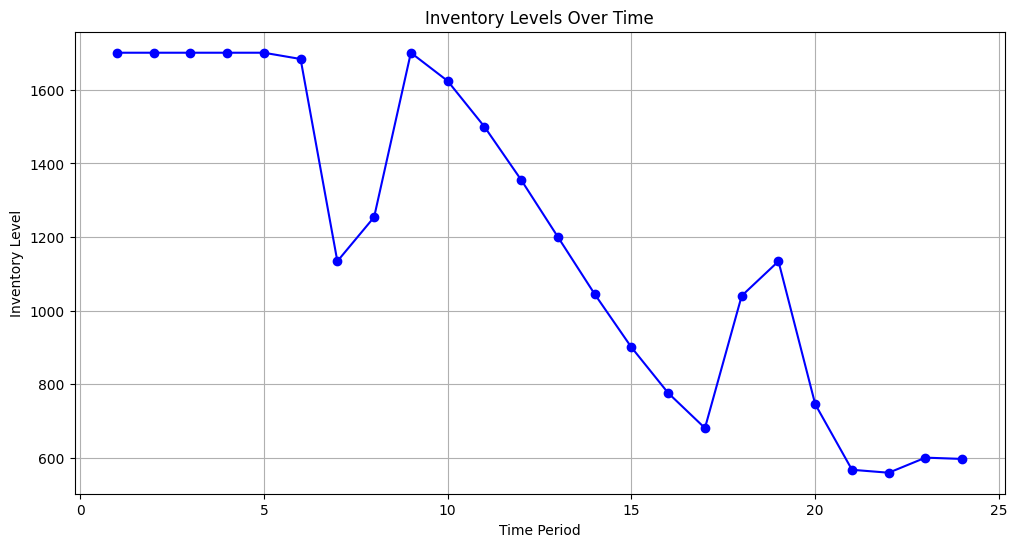

In [8]:
p_value = p.value
inventory_levels = np.sum(p_value, axis=0)
plt.figure(figsize=(12, 6))
plt.plot(t_values, inventory_levels, marker='o', linestyle='-', color='b', label='Inventory Levels')
plt.xlabel('Time Period')
plt.ylabel('Inventory Level')
plt.title('Inventory Levels Over Time')
plt.grid(True)
plt.show()

## References

1. Ben-Tal, Aharon, Alexander Goryashko, Elana Guslitzer, and Arkadi Nemirovski. 2004. Adjustable robust solutions of uncertain linear programs. Mathematical Programming 99(2) 351-376. - add a clickable link